## Import Libraries and Functions

In [1]:
#libraries
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from s3fs.core import S3FileSystem
import numpy as np
import shapefile
#from shapely.geometry.polygon import LinearRing
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import codecs
import json

%matplotlib inline

#functions
from s3_functions import *
from shp_functions import *

## Define constants

In [2]:
s3 = S3FileSystem(anon=True)
bucket = 'ptrac-copano'
extent = (-97.4, -96.6, 27.7, 28.44)
zone_number = 14
zone_letter = 'R'
month_dict = {
    'April': '0401',
    'May': '0501',
    'June': '0601',
    'July': '0701',
    'August': '0801',
}
#s3.




## Read the coordinates, shapefile, and make the plotting mask

In [3]:
print('Reading coordinates')
coords = read_coords(zone_number, zone_letter, extent, s3, bucket)
print('Reading shapefile')
r, polygon, geoms = read_shapefile(s3, bucket)
#print('Creating mask')
#mask, lati, loni = create_mask(coords, polygon)
print('Reading mask')
#need to read it from s3
mask = read_mask(s3, bucket)
#mask = np.array(json.loads(codecs.open(file_path, 'r', encoding='utf_8').read()))
print('Done!')

Reading coordinates
Reading shapefile
Reading mask
Done!


#### Figure out a way to get the mask.json back and into an np array

## Define what happens when buttons are clicked

In [4]:
def read_data(b):
    #since the on_click functions doesn't return anything, need to make these global
    global lat, lon, outflw1, coords, avesal
    
    #get the current state of the dropdown widgets
    year = year_dropdown.get_interact_value()
    month = month_dict[month_dropdown.get_interact_value()]
    
    #create the keys for the lat/lon files, this is their path in S3
    lat_key = 'data/{}/{}/lat.csv'.format(year, month)
    lon_key = 'data/{}/{}/lon.csv'.format(year, month)
    
    #pandas 0.20 uses s3fs to access S3 objects now (previous versions used boto or boto3)
    print('Reading latitude')
    lat = pd.read_csv(s3.open('{}/{}'.format(bucket, lat_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading longitude')
    lon = pd.read_csv(s3.open('{}/{}'.format(bucket, lon_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading velocity')
    outflw1 = read_outflw1(year, month, s3, bucket)
    print('Reading salinity')
    avesal = read_avesalD(year, month, s3, bucket)
    print('Done!')



#### Try to initialize the plot

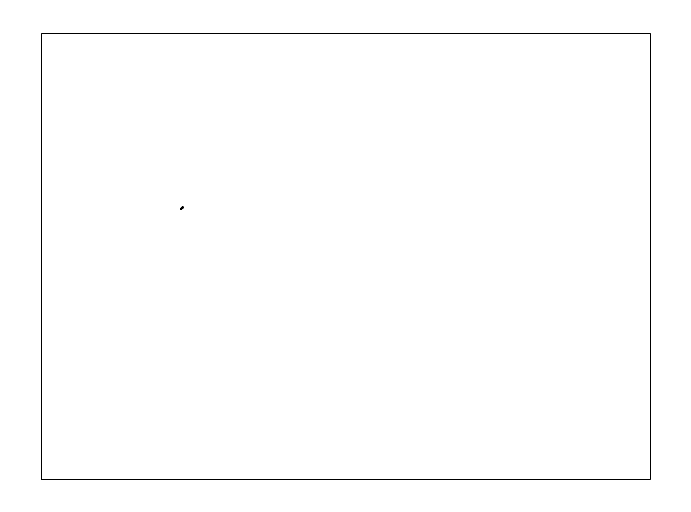

In [5]:
#ring_lats = [28.142815, 28.142622, 28.128572, 28.128588]
#ring_lons = [-97.057931, -97.041549, -97.041542, -97.057923]
#ring = LinearRing(list(zip(ring_lons, ring_lats)))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection=ccrs.Miller())
#ax.set_extent(extent, ccrs.Miller())
ax.add_geometries(geoms, ccrs.Miller(), facecolor='none', edgecolor='black')

In [ ]:
ax.set_extent(extent, ccrs.Miller())

## Create the widgets and buttons

In [5]:
year_dropdown = widgets.Dropdown(
    options = ['1993', '1995', '1997', '2007', '2009', '2011'],
    value = '1993',
    description = 'Year:',
)

month_dropdown = widgets.Dropdown(
    options = ['April', 'May', 'June', 'July', 'August'],
    value = 'April',
    description = 'Month:',
)

submit_button = widgets.Button(
    description = 'Get Data',
    button_style = 'info',
    tooltip = 'Click here to start downloading the appropriate data',
    icon = 'check',
)

display(year_dropdown, month_dropdown, submit_button)

submit_button.on_click(read_data)
#call the plotting function here
#submit_button.on_click(hw)

Reading latitude
Reading longitude
Reading velocity
Reading salinity
Done!
